# Midterm Assignment 1 - Hinge Reviews on The Google Playstore

Importing libraries

In [1]:
import pandas as pd
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
import nltk


import collections
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS

import re
import string

import bitermplus as btm
import tmplot as tmp

Data Preprocessing

In [2]:
df = pd.read_csv('hinge_google_review.csv')

In [3]:
df.head()

reviewId                userName  \
0  005b4acd-94c5-49de-a314-a993090d0a53              Alex Pascu   
1  8365fefd-833d-4763-a250-129b35ee41d5          Nicole Roberge   
2  6e178db6-b4d6-4579-a04c-e67bdde6a907             David Crowe   
3  cbe0b303-ac77-40f0-9a77-245e8c0b5266           Matt Deflavis   
4  4c1e84b8-e25b-44b2-b44a-87cd177737e9  Ian Duda (VortexianZX)   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ACNPE...   
1  https://play-lh.googleusercontent.com/a/ALm5wu...   
2  https://play-lh.googleusercontent.com/a-/ACNPE...   
3  https://play-lh.googleusercontent.com/a-/ACNPE...   
4  https://play-lh.googleusercontent.com/a-/ACNPE...   

                                             content  score  thumbsUpCount  \
0  An algorithm that insists to match you with pe...      1              0   
1  Your app does not work whatsoever.. first of a...      1              0   
2  I would give this app no stars if I could. I s...      1              0   
3  Jumped back on recently, used to use it awhile...      3              0   
4  Talking to a girl and got randomly blocked. To...      5              0   

  reviewCreatedVersion                at replyContent repliedAt  
0                9.9.1   2022-11-05 2:48          NaN       NaN  
1                9.9.1   2022-11-05 1:56          NaN       NaN  
2                  NaN   2022-11-05 1:43          NaN       NaN  
3                9.9.1   2022-11-05 1:03          NaN       NaN  
4                9.9.1  2022-11-04 22:15          NaN       NaN

In [4]:
df.describe()

score  thumbsUpCount
count  58109.000000   58109.000000
mean       3.067993       2.201638
std        1.696079      15.777090
min        1.000000       0.000000
25%        1.000000       0.000000
50%        3.000000       0.000000
75%        5.000000       1.000000
max        5.000000    1169.000000

In [5]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

In [6]:
df.isna().sum()

reviewId                    0
userName                    1
userImage                   0
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion     8174
at                          0
replyContent            57025
repliedAt               57025
dtype: int64

In [7]:
hinge = df.drop(['userImage','reviewCreatedVersion','replyContent','repliedAt'],axis=1)

In [8]:
hinge = hinge.dropna(subset=['content'])

Removing Punctuation, numbers, and lower case

In [9]:
# Load the regular expression library
import re

# Remove punctuation
hinge['review_processed'] = \
hinge['content'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
hinge['review_processed'] = \
hinge['review_processed'].map(lambda x: x.lower())

# Print out the first rows of reviews
hinge['review_processed'].head()

0    an algorithm that insists to match you with pe...
1    your app does not work whatsoever first of all...
2    i would give this app no stars if i could i sp...
3    jumped back on recently used to use it awhile ...
4    talking to a girl and got randomly blocked too...
Name: review_processed, dtype: object

In [10]:
hinge['review_processed'][4503]

"tried to sign up multiple times used my phone number never received the code tried signing up with facebook and it didn't work i was automatically taking to the phone number option only this sucks"

Creating a word cloud to visualize the most common terms

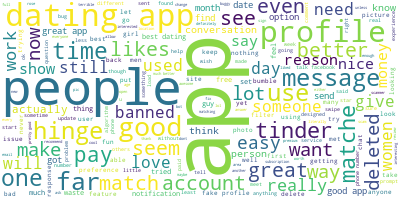

In [11]:
# Join the different processed reviews together.
long_string = ','.join(list(hinge['review_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

With the word cloud we are able to see the most common words. Words like app, profile and hinge will be added to the stopword list

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['app','hinge','profile','apps'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = hinge.review_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:][100][:30])

['whatever', 'ppl', 'saying', 'good', 'theyve', 'definitely', 'turned', 'iy', 'trash', 'algorithm', 'understands', 'preferences', 'dating', 'frontload', 'opposite', 'normal', 'match', 'potentials', 'itll', 'put', 'likely', 'say', 'yes', 'suggestions', 'behind', 'paywall', 'itll', 'suggest', 'pay', 'boosting']


In [13]:
hinge['content_removed'] = remove_stopwords(data_words)

In [14]:
hinge['content_removed'][:3]

0    [algorithm, insists, match, people, like, indi...
1    [work, whatsoever, first, let, upload, pics, p...
2    [would, give, stars, could, spent, lot, money,...
Name: content_removed, dtype: object

# Topic models
Now that the data has been cleaned, it is time to run the four topic model methods; LDA, NMF, CorEX, and BMT

## LDA Model

In [15]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[4503])

[(22, 1), (24, 1), (25, 2), (31, 1), (70, 1), (122, 2), (127, 1), (393, 2), (396, 1), (399, 1), (498, 1), (587, 1), (788, 1), (876, 1), (1767, 1), (2017, 1), (2850, 1)]


The data_words list is converted into a dictionary, and corpus

In [16]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       iterations=10,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       
                                      per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"like" + 0.018*"use" + 0.018*"people" + 0.016*"even" + '
  '0.010*"matches" + 0.009*"get" + 0.008*"good" + 0.008*"profiles" + '
  '0.008*"easy" + 0.007*"want"'),
 (1,
  '0.017*"get" + 0.012*"one" + 0.012*"people" + 0.011*"likes" + 0.011*"even" + '
  '0.008*"like" + 0.007*"day" + 0.007*"account" + 0.007*"dating" + '
  '0.006*"love"'),
 (2,
  '0.054*"good" + 0.021*"people" + 0.015*"get" + 0.014*"far" + 0.012*"matches" '
  '+ 0.011*"like" + 0.009*"time" + 0.008*"message" + 0.006*"send" + '
  '0.006*"even"'),
 (3,
  '0.020*"like" + 0.017*"dating" + 0.013*"tinder" + 0.013*"good" + '
  '0.011*"people" + 0.010*"account" + 0.010*"best" + 0.010*"one" + '
  '0.009*"better" + 0.008*"far"'),
 (4,
  '0.021*"great" + 0.020*"people" + 0.019*"dating" + 0.014*"like" + '
  '0.009*"one" + 0.009*"get" + 0.008*"someone" + 0.007*"profiles" + '
  '0.007*"good" + 0.007*"match"'),
 (5,
  '0.020*"messages" + 0.016*"people" + 0.012*"like" + 0.011*"get" + '
  '0.010*"pay" + 0.009*"matches" + 0.008*"

## LDA Perplexity

In [17]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       iterations=10,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       
                                      per_word_topics=True)


In [18]:
def perplex_values(data):
    values=[]
    iteration=[10]
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       iterations=10,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       
                                      per_word_topics=True)


In [19]:
perplexity = lda_model.log_perplexity(corpus)


In [20]:
print(perplexity)

-7.947109986951206


In [21]:
test =2**(-perplexity)
print(test)

246.7848442364387


## LDA Coherence

In [22]:
#calculating and displaying the coherence score

coherence_model_lda = CoherenceModel(

   model=lda_model, texts=data_words, dictionary=id2word, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()



In [23]:
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -2.7910526659664043


In [24]:
# Compute Coherence Score using u_mass
coherence_model_lda = CoherenceModel(

   model=lda_model, texts=data_words, dictionary=id2word, coherence='u_mass')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(1,num_topics+1):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname,coherence_ldas)
plt.title('Coherence Score Topic')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


Coherence Score:  [-2.665319742271231, -2.5598754668546135, -2.8534169468505346, -2.6515708358813264, -2.6645617347571435, -3.083271730913079, -2.5246240686842425, -3.332293997156342, -2.8999375453078016, -2.6756545909877296]


# NMF Model

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text


from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
df = pd.read_csv('hinge_google_review.csv')


In [26]:
df.head()

reviewId                userName  \
0  005b4acd-94c5-49de-a314-a993090d0a53              Alex Pascu   
1  8365fefd-833d-4763-a250-129b35ee41d5          Nicole Roberge   
2  6e178db6-b4d6-4579-a04c-e67bdde6a907             David Crowe   
3  cbe0b303-ac77-40f0-9a77-245e8c0b5266           Matt Deflavis   
4  4c1e84b8-e25b-44b2-b44a-87cd177737e9  Ian Duda (VortexianZX)   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ACNPE...   
1  https://play-lh.googleusercontent.com/a/ALm5wu...   
2  https://play-lh.googleusercontent.com/a-/ACNPE...   
3  https://play-lh.googleusercontent.com/a-/ACNPE...   
4  https://play-lh.googleusercontent.com/a-/ACNPE...   

                                             content  score  thumbsUpCount  \
0  An algorithm that insists to match you with pe...      1              0   
1  Your app does not work whatsoever.. first of a...      1              0   
2  I would give this app no stars if I could. I s...      1              0   
3  Jumped back on recently, used to use it awhile...      3              0   
4  Talking to a girl and got randomly blocked. To...      5              0   

  reviewCreatedVersion                at replyContent repliedAt  
0                9.9.1   2022-11-05 2:48          NaN       NaN  
1                9.9.1   2022-11-05 1:56          NaN       NaN  
2                  NaN   2022-11-05 1:43          NaN       NaN  
3                9.9.1   2022-11-05 1:03          NaN       NaN  
4                9.9.1  2022-11-04 22:15          NaN       NaN

In [27]:
hinge = df.drop(['userImage','reviewCreatedVersion','replyContent','repliedAt'],axis=1)

In [28]:
hinge = hinge.dropna(subset=['content'])

In [29]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''    
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)    
    
    return text

In [30]:
round1 = lambda x: clean_text_round1(x)

# Clean Speech Text
hinge["content"] = hinge["content"].apply(round1)

# Visually Inspect
hinge.head()

reviewId                userName  \
0  005b4acd-94c5-49de-a314-a993090d0a53              Alex Pascu   
1  8365fefd-833d-4763-a250-129b35ee41d5          Nicole Roberge   
2  6e178db6-b4d6-4579-a04c-e67bdde6a907             David Crowe   
3  cbe0b303-ac77-40f0-9a77-245e8c0b5266           Matt Deflavis   
4  4c1e84b8-e25b-44b2-b44a-87cd177737e9  Ian Duda (VortexianZX)   

                                             content  score  thumbsUpCount  \
0  an algorithm that insists to match you with pe...      1              0   
1  your app does not work whatsoever   first of a...      1              0   
2  i would give this app no stars if i could  i s...      1              0   
3  jumped back on recently  used to use it awhile...      3              0   
4  talking to a girl and got randomly blocked  to...      5              0   

                 at  
0   2022-11-05 2:48  
1   2022-11-05 1:56  
2   2022-11-05 1:43  
3   2022-11-05 1:03  
4  2022-11-04 22:15

In [31]:
# Noun extract and lemmatize function

def nouns(text):
    #Given a string of text, tokenize the text 
    #and pull out only the nouns.   
    
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'    
    
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)    
    
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()    
    
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

# Create dataframe of only nouns from speeches
data_nouns = pd.DataFrame(hinge.content.apply(nouns))
hinge['content_processed'] = pd.DataFrame(hinge.content.apply(nouns))

# Visually Inspect
data_nouns.head()

content
0    algorithm people t indifferent sense waste time
1  app pic phone option fb picture people pic not...
2  i app star i lot money rose response like anyt...
3               limit like day message issue app app
4            girl l kinda ngl app quality connection

In [32]:
# Add additional stop words since we are recreating the document-term matrix
stop_noun = ['app', 'apps','hinge','profile','people','message','site','dating','date']
stop_words_noun_agg = text.ENGLISH_STOP_WORDS.union(stop_noun)

# Create a document-term matrix with only nouns

# Store TF-IDF Vectorizer
tv_noun = TfidfVectorizer(stop_words=stop_words_noun_agg, ngram_range = (1,1), max_df = .8, min_df = .01)


# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_tv_noun = tv_noun.fit_transform(data_nouns.content)

# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names())

# Set President's Names as Index
#data_dtm_noun.index = df.index

# Visually inspect Document Term Matrix
data_dtm_noun.head(10)


account  age  algorithm  area  bug  chat  concept  connection  \
0  0.000000  0.0   0.659166   0.0  0.0   0.0      0.0    0.000000   
1  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   
2  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   
3  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   
4  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.615152   
5  0.662191  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   
6  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   
7  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   
8  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   
9  0.000000  0.0   0.000000   0.0  0.0   0.0      0.0    0.000000   

   conversation  customer  ...      time  tinder  user   ve     waste  way  \
0           0.0       0.0  ...  0.440927     0.0   0.0  0.0  0.609166  0.0   
1           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   
2           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.345872  0.0   
3           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   
4           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   
5           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   
6           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   
7           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   
8           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   
9           0.0       0.0  ...  0.000000     0.0   0.0  0.0  0.000000  0.0   

   week  woman  work  year  
0   0.0    0.0   0.0   0.0  
1   0.0    0.0   0.0   0.0  
2   0.0    0.0   0.0   0.0  
3   0.0    0.0   0.0   0.0  
4   0.0    0.0   0.0   0.0  
5   0.0    0.0   0.0   0.0  
6   0.0    0.0   0.0   0.0  
7   0.0    0.0   0.0   0.0  
8   0.0    0.0   0.0   0.0  
9   0.0    0.0   0.0   0.0  

[10 rows x 60 columns]

In [33]:
def display_topics(model, feature_names, num_top_words,topic_names=None):

    for ix, topic in enumerate(model.components_):        
        
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic  " , ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [34]:
nmf_model = NMF(10)

doc_topic = nmf_model.fit_transform(data_dtm_noun)

display_topics(nmf_model, tv_noun.get_feature_names(), 10)


Topic   0
match, quality, month, week, notification, money, algorithm, feature, preference, chat

Topic   1
time, waste, money, don, month, phone, notification, person, number, work

Topic   2
like, money, number, month, pay, thing, subscription, feature, user, week

Topic   3
tinder, quality, girl, thing, user, ve, week, guy, feature, money

Topic   4
account, reason, number, service, phone, month, facebook, money, customer, support

Topic   5
way, thing, person, photo, picture, connection, preference, money, age, question

Topic   6
woman, men, preference, money, girl, guy, quality, algorithm, option, area

Topic   7
lot, girl, option, money, feature, bug, guy, fun, area, thing

Topic   8
day, month, girl, subscription, notification, week, star, guy, person, service

Topic   9
conversation, experience, person, notification, thing, user, option, ve, picture, question


In [35]:
for topic in range(10):
    tmp = data_dtm_noun.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
algorithm     0.659166
waste         0.609166
time          0.440927
account       0.000000
age           0.000000
area          0.000000
bug           0.000000
chat          0.000000
concept       0.000000
connection    0.000000
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
picture      0.589697
phone        0.574598
option       0.567534
account      0.000000
age          0.000000
algorithm    0.000000
area         0.000000
bug          0.000000
chat         0.000000
concept      0.000000
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
money        0.610232
response     0.358851
waste        0.345872
star         0.341784
person       0.314236
lot          0.297203
like         0.274455
account      0.000000
age          0.000000
algorithm    0.000000
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
issue        0.656877
day          0.539552
like    

# CorEX Models

In [36]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

import corextopic.corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline




In [37]:
data_tv_noun.shape

(58107, 60)

In [38]:
# Transform 20 newsgroup data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', binary=True)
doc_word = vectorizer.fit_transform(hinge.content_processed)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(58107, 9228)

In [39]:
words = list(np.asarray(vectorizer.get_feature_names()))

In [40]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(58107, 9228)

In [41]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=45, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [42]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=1, n_words=10)

[('breaker', 0.01721529309244459, 1.0),
 ('deal', 0.013849257929852468, 1.0),
 ('term', 0.013779470655367325, 1.0),
 ('card', 0.006313648792576829, 1.0),
 ('condition', 0.005733845598197307, 1.0),
 ('violation', 0.005133803116172599, 1.0),
 ('ice', 0.004398043958096571, 1.0),
 ('business', 0.004384318277422182, 1.0),
 ('play', 0.003941981654798666, 1.0),
 ('store', 0.0036814792101051096, 1.0)]

In [43]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: account, service, customer, reason, support, email, explanation, appeal, ban, refund
1: breaker, deal, term, card, condition, violation, ice, business, play, store
2: people, woman, men, preference, mile, distance, area, age, lot, date
3: message, notification, chat, issue, doesn, bug, work, update, send, load
4: time, phone, number, waste, hinge, problem, ve, matter, page, end
5: question, prompt, conversation, picture, answer, comment, thing, starter, bio, voice
6: money, month, week, rose, standouts, profile, membership, don, response, section
7: verification, code, facebook, sign, login, log, fb, process, registration, wouldn
8: pay, wall, algorithm, cash, grab, girl, paywall, breath, air, car
9: location, city, town, neighborhood, country, map, ghost, border, canada, life
10: day, like, match, couple, price, dollar, fact, list, dislike, increase
11: type, person, body, filter, weight, personality, height, look, face, race
12: vice, use, versa, ease, hair, press, bell, pls, idio

In [44]:

print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[15  1 11 ...  0  0  0]
(9228,)


In [45]:

# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(8690, 0.0),
 (4638, 0.0),
 (7746, 0.0),
 (43985, 0.0),
 (16098, 0.0),
 (3549, 0.0),
 (11277, 0.0),
 (5292, 0.0),
 (1577, 0.0),
 (1848, 0.0)]

In [46]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(58107, 45)


In [47]:

print(topic_model.labels.shape) # n_docs x k_topics

(58107, 45)


In [48]:
topic_model.tc

0.9168665114951041

In [49]:
topic_model.tcs.shape # k_topics

(45,)

In [50]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

0.9168665114951041
0.9168665114951041


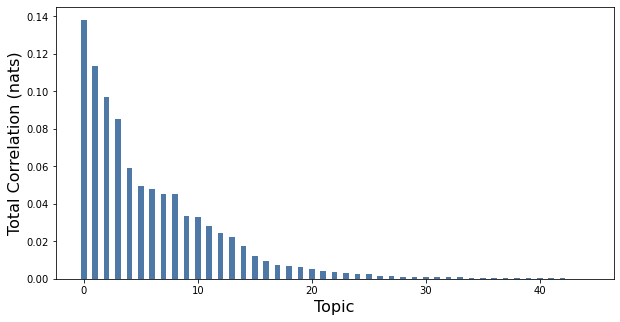

In [51]:

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('corEX_correlation')

The first topic contains words pertaining to technical issues with the app such as account, service, support, and customer which is to be expected

In [52]:
topic_model.get_topics(topic=1, n_words=10, print_words=True)

[('breaker', 0.01721529309244459, 1.0),
 ('deal', 0.013849257929852468, 1.0),
 ('term', 0.013779470655367325, 1.0),
 ('card', 0.006313648792576829, 1.0),
 ('condition', 0.005733845598197307, 1.0),
 ('violation', 0.005133803116172599, 1.0),
 ('ice', 0.004398043958096571, 1.0),
 ('business', 0.004384318277422182, 1.0),
 ('play', 0.003941981654798666, 1.0),
 ('store', 0.0036814792101051096, 1.0)]

In [53]:
topic_model.log_z.shape # n_docs x k_topics

(58107, 45)

In [54]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

[1.38114137e-01 1.13525852e-01 9.69146720e-02 8.52517930e-02
 5.90303042e-02 4.95093600e-02 4.81530332e-02 4.54761160e-02
 4.51465349e-02 3.34796146e-02 3.31168005e-02 2.83395368e-02
 2.44960525e-02 2.23780070e-02 1.76809558e-02 1.22295784e-02
 9.66917678e-03 7.17510485e-03 6.79507034e-03 6.15409507e-03
 4.99882721e-03 4.17164570e-03 3.61512665e-03 3.19344265e-03
 2.68503599e-03 2.43670147e-03 1.60400711e-03 1.58996435e-03
 1.17431062e-03 1.16964247e-03 1.01118382e-03 8.91014502e-04
 8.23927399e-04 7.10217925e-04 6.56025337e-04 6.20590814e-04
 5.39569686e-04 5.27498524e-04 4.67409318e-04 3.66469023e-04
 3.21584447e-04 3.06633404e-04 1.66471732e-04 1.03263466e-04
 8.01526766e-05]
[1.38114137e-01 1.13525852e-01 9.69146720e-02 8.52517930e-02
 5.90303042e-02 4.95093600e-02 4.81530332e-02 4.54761160e-02
 4.51465349e-02 3.34796146e-02 3.31168005e-02 2.83395368e-02
 2.44960525e-02 2.23780070e-02 1.76809558e-02 1.22295784e-02
 9.66917678e-03 7.17510485e-03 6.79507034e-03 6.15409507e-03
 4.9988

## CorEX - Anchored Words

In [55]:
anchor_words = ['account','breaker','people','message','time','question','money','verification','pay','location']

In [56]:

anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [57]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: account, reason, create, guideline, prefill, thief, spam, check, sc, december
1: breaker, hinge, app, profile, match, person, woman, day, month, thing
2: people, area, meeting, range, talk, alot, mix, canada, variety, allows
3: message, notification, chat, send, bug, messaging, glitch, load, update, sent
4: time, waste, don, waster, waist, period, garbage, energy, min, spent
5: question, answer, karo, shirt, office, paragraph, pre, koi, tan, podcast
6: money, grab, subscription, company, scam, scammer, card, fraud, hungry, gift
7: verification, phone, number, customer, service, support, code, facebook, email, term
8: pay, wall, die, hide, pursuit, mit, ist, converse, nichts, forbid
9: location, mile, distance, city, map, neighborhood, state, country, setting, town


# BTM Model

In [58]:
import bitermplus as btm
import numpy as np
import pandas as pd

import tmplot as tmp


In [59]:
df = pd.read_csv(
    'hinge_google_review.csv')
df = df.dropna(subset=['content'])

In [60]:
df.head()

reviewId                userName  \
0  005b4acd-94c5-49de-a314-a993090d0a53              Alex Pascu   
1  8365fefd-833d-4763-a250-129b35ee41d5          Nicole Roberge   
2  6e178db6-b4d6-4579-a04c-e67bdde6a907             David Crowe   
3  cbe0b303-ac77-40f0-9a77-245e8c0b5266           Matt Deflavis   
4  4c1e84b8-e25b-44b2-b44a-87cd177737e9  Ian Duda (VortexianZX)   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ACNPE...   
1  https://play-lh.googleusercontent.com/a/ALm5wu...   
2  https://play-lh.googleusercontent.com/a-/ACNPE...   
3  https://play-lh.googleusercontent.com/a-/ACNPE...   
4  https://play-lh.googleusercontent.com/a-/ACNPE...   

                                             content  score  thumbsUpCount  \
0  An algorithm that insists to match you with pe...      1              0   
1  Your app does not work whatsoever.. first of a...      1              0   
2  I would give this app no stars if I could. I s...      1              0   
3  Jumped back on recently, used to use it awhile...      3              0   
4  Talking to a girl and got randomly blocked. To...      5              0   

  reviewCreatedVersion                at replyContent repliedAt  
0                9.9.1   2022-11-05 2:48          NaN       NaN  
1                9.9.1   2022-11-05 1:56          NaN       NaN  
2                  NaN   2022-11-05 1:43          NaN       NaN  
3                9.9.1   2022-11-05 1:03          NaN       NaN  
4                9.9.1  2022-11-04 22:15          NaN       NaN

In [61]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''    
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)    
    
    return text

In [62]:
round1 = lambda x: clean_text_round1(x)

# Clean Speech Text
df["content"] = df["content"].apply(round1)

# Visually Inspect
df.head()

reviewId                userName  \
0  005b4acd-94c5-49de-a314-a993090d0a53              Alex Pascu   
1  8365fefd-833d-4763-a250-129b35ee41d5          Nicole Roberge   
2  6e178db6-b4d6-4579-a04c-e67bdde6a907             David Crowe   
3  cbe0b303-ac77-40f0-9a77-245e8c0b5266           Matt Deflavis   
4  4c1e84b8-e25b-44b2-b44a-87cd177737e9  Ian Duda (VortexianZX)   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ACNPE...   
1  https://play-lh.googleusercontent.com/a/ALm5wu...   
2  https://play-lh.googleusercontent.com/a-/ACNPE...   
3  https://play-lh.googleusercontent.com/a-/ACNPE...   
4  https://play-lh.googleusercontent.com/a-/ACNPE...   

                                             content  score  thumbsUpCount  \
0  an algorithm that insists to match you with pe...      1              0   
1  your app does not work whatsoever   first of a...      1              0   
2  i would give this app no stars if i could  i s...      1              0   
3  jumped back on recently  used to use it awhile...      3              0   
4  talking to a girl and got randomly blocked  to...      5              0   

  reviewCreatedVersion                at replyContent repliedAt  
0                9.9.1   2022-11-05 2:48          NaN       NaN  
1                9.9.1   2022-11-05 1:56          NaN       NaN  
2                  NaN   2022-11-05 1:43          NaN       NaN  
3                9.9.1   2022-11-05 1:03          NaN       NaN  
4                9.9.1  2022-11-04 22:15          NaN       NaN

In [63]:
round2 = lambda x:" ".join(x)

In [64]:
df["content"] 

0        an algorithm that insists to match you with pe...
1        your app does not work whatsoever   first of a...
2        i would give this app no stars if i could  i s...
3        jumped back on recently  used to use it awhile...
4        talking to a girl and got randomly blocked  to...
                               ...                        
58104    useless   i m in the uk and it tells me i m ov...
58105    i can t get past the initial set up   it won t...
58106    this is incredible  a quality dating app for a...
58107               over water      can t choose location 
58108    my entire town counts as  over water  and i ca...
Name: content, Length: 58107, dtype: object

In [65]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['app','hinge','profile','apps'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.content.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
df['content_removed']= remove_stopwords(data_words)

In [66]:
df['content_removed']

0        [algorithm, insists, match, people, like, indi...
1        [work, whatsoever, first, let, upload, pics, p...
2        [would, give, stars, could, spent, lot, money,...
3        [jumped, back, recently, used, use, awhile, ba...
4        [talking, girl, got, randomly, blocked, took, ...
                               ...                        
58104    [useless, uk, tells, water, let, get, running,...
58105    [get, past, initial, set, set, neighborhood, t...
58106    [incredible, quality, dating, android, boyfrie...
58107                            [water, choose, location]
58108       [entire, town, counts, water, cannot, proceed]
Name: content_removed, Length: 58107, dtype: object

In [67]:
df["content_removed"] = df["content_removed"].apply(round2)

In [68]:
df["content_removed"]

0        algorithm insists match people like indifferen...
1        work whatsoever first let upload pics phone ga...
2        would give stars could spent lot money especia...
3        jumped back recently used use awhile back adde...
4        talking girl got randomly blocked took fat kin...
                               ...                        
58104    useless uk tells water let get running little ...
58105    get past initial set set neighborhood thinks n...
58106      incredible quality dating android boyfriend wya
58107                                water choose location
58108              entire town counts water cannot proceed
Name: content_removed, Length: 58107, dtype: object

In [69]:
texts = df['content_removed'].str.strip().tolist()

In [70]:
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [71]:
# INITIALIZING AND RUNNING MODEL
model = btm.BTM(
    X, vocabulary, seed=12321, T=10, M=20, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=20)
p_zd = model.transform(docs_vec)

100%|█████████████████████████████████| 58107/58107 [00:00<00:00, 161747.10it/s]


In [72]:
# METRICS
perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 10)
coherence = btm.coherence(model.matrix_topics_words_, X, M=20)


In [73]:
perplexity

962.3647329773468

In [74]:
coherence

array([-468.26379957, -487.34208346, -537.57014765, -508.39477903,
       -493.98130935, -460.51499632, -470.69531403, -505.17542296,
       -497.5374632 , -514.56135874])

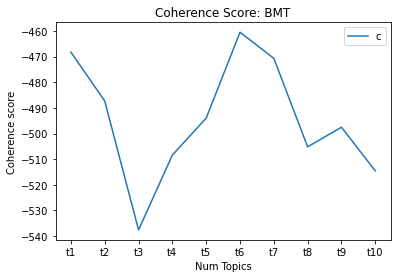

In [75]:

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(1,11):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname,coherence)
plt.title('Coherence Score: BMT')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('bmt_coherence.png')
plt.show()


In [76]:
import tmplot as tmp

In [77]:
tmp.report(model=model, docs=texts, width=250)

In [78]:
phi = tmp.get_phi(model)
phi.head()


topics               0             1             2             3  \
words                                                              
aa        1.062958e-08  1.114947e-08  1.023968e-08  8.439422e-09   
aaa       1.062958e-08  1.114947e-08  1.023968e-08  8.439422e-09   
aaaa      1.062958e-08  1.114947e-08  1.023968e-08  8.439422e-09   
aaaaaaaa  1.062958e-08  1.114947e-08  1.023968e-08  8.439422e-09   
aaadhar   1.062958e-08  1.114947e-08  1.023968e-08  1.696324e-06   

topics               4             5             6             7  \
words                                                              
aa        1.224438e-08  1.465366e-08  1.239847e-08  1.367788e-08   
aaa       1.224438e-08  1.465366e-08  1.239847e-08  1.367788e-08   
aaaa      1.224438e-08  1.465366e-08  1.239847e-08  1.367788e-08   
aaaaaaaa  1.224438e-08  1.465366e-08  1.365071e-05  1.367788e-08   
aaadhar   4.909996e-06  1.465366e-08  1.239847e-08  1.367788e-08   

topics               8             9  
words                                 
aa        1.235441e-08  1.109022e-08  
aaa       1.235441e-08  4.447178e-06  
aaaa      1.235441e-08  1.109022e-08  
aaaaaaaa  1.235441e-08  1.109022e-08  
aaadhar   1.235441e-08  3.338156e-06

In [79]:
tmp.get_theta(model).head()

docs       0         1         2         3         4         5         6      \
topics                                                                         
0       0.040720  0.084560  0.059507  0.256258  0.071188  0.058666  0.017940   
1       0.022884  0.073240  0.107989  0.074944  0.179973  0.428925  0.004451   
2       0.107266  0.031759  0.116855  0.091628  0.026639  0.081928  0.137449   
3       0.366390  0.012968  0.092201  0.084482  0.121901  0.013692  0.132158   
4       0.035510  0.355566  0.042821  0.091326  0.034403  0.100920  0.005946   

docs       7         8         9      ...     58097     58098     58099  \
topics                                ...                                 
0       0.123740  0.395602  0.069214  ...  0.084151  0.067317  0.165488   
1       0.125754  0.018593  0.007361  ...  0.028057  0.090747  0.034664   
2       0.051583  0.000915  0.052303  ...  0.127180  0.109026  0.110134   
3       0.187551  0.000511  0.367845  ...  0.062508  0.064958  0.023503   
4       0.036274  0.502914  0.032102  ...  0.265476  0.186662  0.393476   

docs       58100     58101     58102     58103     58104     58105     58106  
topics                                                                        
0       0.126974  0.116383  0.133503  0.166973  0.070853  0.074468  0.050185  
1       0.016644  0.001253  0.061923  0.022453  0.000810  0.000482  0.005746  
2       0.072804  0.115029  0.066058  0.203352  0.001500  0.176262  0.113882  
3       0.001646  0.048734  0.062623  0.007696  0.187566  0.011234  0.004118  
4       0.584252  0.174646  0.262039  0.151759  0.056628  0.380666  0.346371  

[5 rows x 58107 columns]

In [80]:
tmp.get_top_docs(texts, model=model)

topic0                   topic1  \
0                      lajawaab subhanallah atiuttam  hasta ahorita todo bien   
1  tenu pata ni shayad magar ishq vich nahi chald...                dhj ch uy   
2                                        soft weldon               yummy yumm   
3                                              ds ra            banned reasom   
4                                    nigigity nogity          sex trafficking   

              topic2                              topic3  \
0     muy excellente                      dik va jay jay   
1  eugenics eugenics                 bigtime awesomeness   
2         muy bueono  heeeeelllpp meeeeeeeee ceeakyvoice   
3      full lunatics                 interactive dynamic   
4       gyal butters                       better rivals   

                 topic4                     topic5  \
0            dekhte hei               maha bakwaas   
1            ekta baler              datey whatnot   
2           das ist gut  bandi achi dhund deta hai   
3     tech difficulties                    tee hee   
4  supportive polyamory                   mast hai   

                                              topic6             topic7  \
0                               lowered expectations         goood appp   
1                                                 er     shockingly bad   
2                                                 op  trustworthy forum   
3  de op zich prima maar een straal van zijn er p...         pure totty   
4                             expensive unproductive           fuc yall   

                     topic8                       topic9  
0                 aight moi  𝓜𝓸𝓷𝓽𝓱 𝓘𝓽 𝓞𝓚 𝓑𝓾𝓽 𝓝𝓸𝓽 𝓣𝓱𝓪𝓽 𝓞𝓚  
1  scrim scram skippity doo                  yawn zzzzzz  
2                peng tings       humne ladki kab milegi  
3              fatties ugos                    que bueno  
4                non shabby                       nj uhh

In [81]:
topics_coords = tmp.prepare_coords(model)
topics_coords.head(8)

x          y  topic       size  label
0  10.742900 -14.140069      0   9.902066      0
1 -22.887390 -37.078388      1   7.288193      1
2   8.185929  46.213673      2   8.741281      2
3 -14.644040  68.522675      3  22.046796      3
4  -1.644764 -27.791430      4   7.610868      4
5 -16.472979  -2.807173      5   6.609118      5
6   5.319948  22.753689      6   8.638188      6
7 -14.086977  15.989739      7   8.095025      7

In [82]:
tmp.plot_scatter_topics(topics_coords, size_col='size', label_col='label')


alt.LayerChart(...)

In [102]:
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=1, lambda_=0.5)
terms_probs['Terms'][:10]

0         refute
1          maria
2          baned
3       enquired
4      resolving
5         boiler
6          infos
7       insisted
8    overturning
9            vax
Name: Terms, dtype: object

In [105]:
for i in range(10):
    terms_probs = tmp.calc_terms_probs_ratio(phi, topic=i, lambda_=0.5)
    print('Topic:',i+1)
    print(terms_probs['Terms'][:10])
    print('\n')

Topic: 1
0         oops
1     crafting
2        bells
3       cheesy
4    miserably
5     occurred
6        gplay
7         pump
8     vanishes
9      arrives
Name: Terms, dtype: object


Topic: 2
0         refute
1          maria
2          baned
3       enquired
4      resolving
5         boiler
6          infos
7       insisted
8    overturning
9            vax
Name: Terms, dtype: object


Topic: 3
0       cashgrab
1    neighboring
2     preferance
3       flooding
4            exp
5     segregates
6    perferances
7      travelers
8         senior
9     distinctly
Name: Terms, dtype: object


Topic: 4
0         poeple
1            yeh
2        fancier
3       graphics
4           role
5     definetely
6    personalise
7          ethos
8        incites
9        barrier
Name: Terms, dtype: object


Topic: 5
0          provider
1           council
2            accout
3           bloated
4        photoshoot
5            suburb
6    reinstallation
7            switxh
8          selector

In [104]:
terms_probs.head(10)

Terms                             Type  Probability
0          mis  Marginal term probability, p(w)     0.000115
1        faqin  Marginal term probability, p(w)     0.000087
2         memo  Marginal term probability, p(w)     0.000084
3   behaviours  Marginal term probability, p(w)     0.000079
4      earning  Marginal term probability, p(w)     0.000069
5        greet  Marginal term probability, p(w)     0.000064
6     tasteful  Marginal term probability, p(w)     0.000064
7  cultivating  Marginal term probability, p(w)     0.000061
8      fittest  Marginal term probability, p(w)     0.000060
9          hip  Marginal term probability, p(w)     0.000058

In [85]:
tmp.plot_terms(terms_probs)

alt.Chart(...)